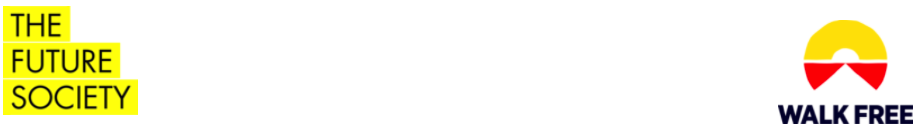

#*Project AIMS (AI against Modern Slavery)*

---




##💻 Note: You can run this notebook locally or on Google Colab following this [link](https://drive.google.com/file/d/1iucDX6t1dIBA0ehZfUDmyx8GZ9aMECSr/view?usp=sharing).

# Ownership Disclosure#

## Does the company disclose the ownership structure(s) and/or business model(s) of each of its brands, subsidiaries, and other businesses covered by their Modern Slavery statement?
 
This task aims to check whether the companies disclose anything related to the ownership structure or their business model. This relates to its brands, subsidiaries, and other businesses.
 
The UK Modern Slavery Act requires organisations to disclose their structure, business model, and supply chains. This is to understand the boundaries of the statements mentioned in the report and to support the identification of risk based on the business models, type of business, location of business and supply chains and goods and services sourced, and workforce.
 
Stating an ownership structure or business model can include whether the businesses, brands, subsidiaries are:

* Owned and managed by the reporting company
*Leased for a duration of time
*Managed property by some 3rd organisation
*Franchised property
*A joint venture between some other company or organisation




 
Any of this information disclosed by the company will help identify the businesses at high risk of getting exposed to modern slavery, which business models are ideal in terms of human rights management, which types of business models are more vulnerable to getting exposed to the incidents, etc.

Please refer to [WikiRate's UK Modern Slavery Act Research on Ownership Disclosure metric](https://wikirate.org/Walk_Free_Foundation+MSA_Ownership_Disclosure) or the [UK Government 2015, “Modern Slavery Act”](http://www.legislation.gov.uk/ukpga/2015/30/section/54/enacted) for further information on this metric.
 
### Labeled dataset
Any statement that discloses such ownership structure or business model information is labelled with ‘Yes/1’, while statements that did not disclose any such information are labelled as ‘No/ 0’.

 




In [ ]:
#!pip install snorkel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/ProjectAIMS

/content/drive/.shortcut-targets-by-id/11tRyVLvElSSvedZDsiP76NndaI3wNyFb/Project AIMS


## 1. Setup

In [ ]:
import spacy
import en_core_web_sm
import pandas as pd
import re
import tqdm
import snorkel
import nltk 
from nltk import word_tokenize, pos_tag
from utils import sentencizer, evaluation_rb
from snorkel.labeling import labeling_function
from snorkel.labeling.model import LabelModel
from snorkel.labeling import LabelingFunction
from snorkel.labeling import PandasLFApplier
from snorkel.labeling import LFAnalysis
from snorkel.labeling.model import MajorityLabelVoter


nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nlp = en_core_web_sm.load()
nlp.add_pipe(sentencizer.custom_sentencizer, before="parser")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### 🗄️ You can access the data used in this notebook [here ](https://drive.google.com/file/d/1gr9PbPTaYLnhVKJ6eraJboPmvLZ_E14J/view?usp=sharing). We recommend you re-run this research with an updated version of this data which can be downloaded following these [instructions](https://github.com/the-future-society/Project-AIMS-AI-against-Modern-Slavery/tree/main/%F0%9F%97%84%EF%B8%8F%20Data%20and%20text%20extraction/WikiRate).



In [ ]:
metric = 'Walk Free Foundation+MSA Ownership Disclosure'
metric_binary = metric +' binary'

In [ ]:
labeled_dataset = pd.read_csv("labeled-dataset.csv", dtype=object,  index_col=0)
print('Number of available statements for {} -> {:,}\n'.format(metric, labeled_dataset.shape[0]))

Number of available statements for Walk Free Foundation+MSA Ownership Disclosure -> 2,749



In [ ]:
# select relevant columns
columns = ['Answer ID', 'Answer Link', 'Metric', 'Company', 'Year', 'Value', 'Source', 'TEXT', metric]
data = labeled_dataset[columns]

# Remove unknown values from metric column
data = data.loc[(data[metric] != "Unknown") & (data[metric] != "unknown") & (data[metric] != " ") ,:]

# Remove empty values from metric column
data = data[data[metric].notna()]

# Remove rows with empty text cells
data = data[data['TEXT'].notna()]

#remove rows with duplicated text 
data = data.drop_duplicates(subset = 'TEXT')
print("After removing duplicates and empty values the shape is",data.shape)

After removing duplicates and empty values the shape is (580, 9)


In [ ]:
print("Final number of data points in the labeled dataset is:")
print(data[metric].value_counts())

Final number of data points in the labeled dataset is:
Yes    342
No     238
Name: Walk Free Foundation+MSA Ownership Disclosure, dtype: int64


In [ ]:
# define a binary metric
no_values = ['No']

In [ ]:
data[metric_binary] = [1 if value not in no_values else 0 for value in data[metric]]

The sentences are checked if they contain the keywords to see if those sentences explain anything about the ownership structure of the business. Before that, initial pre-processing tasks are performed on the data, including removing empty text values, removing empty metric values, and removal of duplicate data rows, etc. After preprocessing of data, 580 statements remain. Out of these, 342 statements were labelled with ‘Yes/1’, which means they explain some information about the ownership structure of the data. Also, 238 statements do not disclose any information about it and have ‘No’ as a label. The number of statements in the positive class is slightly greater than the number of statements in the negative class. However, overall the data is very scarce for this metric.

The keywords considered while checking if the sentence is related to the ownership structure or business model of a company are in the raw form, such as ‘wholly-owned subsidiaries’, ‘operates as part of a group of companies’, etc. These phrases need some processing in terms of extracting the lemmas with the help of lemmatisation to lower the cases of the words in the phrases, etc. After, the pre-processing of the final set of keywords/phrases consists of below elements: 'branch', 'hold company', 'include follow wholly own subsidiary', 'main operating company', 'operate group company', 'parent company', 'subsidiary', 'subsidiary company', 'wholly own'.



In [ ]:
few_keywords = [" includes the following wholly owned subsidiaries", "operates as part of a group of companies", 
                "subsidiary companies", "main operating companies", "subsidiary of", "branches", " wholly-owned", "holding company", "parent company"]


In [ ]:
def get_keyword_lemmas(keywords_list):
    """
    Given a list of keyword combinations, extract lemmas from them.
    :param keywords_list: provided list of keywords describing a particular metric.
    """
    keywords_lemmas = list()
    for doc in nlp.pipe(keywords_list):
        keyword_lemma = [t.lemma_.lower() for t in doc if (not t.is_punct) and (not t.is_stop) and (not t.is_space) ]
        keyword_lemma = ' '.join(keyword_lemma)
        keywords_lemmas.append( keyword_lemma)

    keywords_lemmas = set(keywords_lemmas)

    return keywords_lemmas


In [ ]:
few_keywords_lemmas = get_keyword_lemmas(few_keywords)
few_keywords_lemmas

{'branch',
 'hold company',
 'include follow wholly own subsidiary',
 'main operating company',
 'operate group company',
 'parent company',
 'subsidiary',
 'subsidiary company',
 'wholly own'}

The next step is to check how many of the above keywords are present in the sentence and extract them into a single list for each sentence. The new feature named Extract is maintained, which has a list of the keywords present in the sentence from the keywords. This is done by parsing and searching the sentences with the use of the Spacy package for the keywords and then extracting them into a special list. 
 
A labelling function is created. If the extract list is empty, then that sentence is labelled as 0; otherwise, it is labelled as 1. But this is done by using Snorkel’s weak supervision labelling task. This contains many functions present In the Snorkel package like LFAnalysis, MajorityLabelVoter, etc. The analysis function is used to understand the different metrics like coverage, polarity and check for the conflicts in the result. MajorityLabelVoter is used to perform the classification task to predict the label.
 
The output of the system is a prediction about whether a sentence could be classified as containing relevant information about the ownership disclosure or not. 
 

In [ ]:
def tense(sentence):
    text = word_tokenize(sentence)
    tagged = pos_tag(text)

    tense = {}
    tense["future"] = len([word for word in tagged if word[1] == "MD"])
    tense["present"] = len([word for word in tagged if word[1] in ["VBP", "VBZ","VBG"]])
    tense["past"] = len([word for word in tagged if word[1] in ["VBD", "VBN"]]) 

    if max(tense, key=tense.get) == 0:
        return 'present'
    else:
        return max(tense, key=tense.get)

In [ ]:
def get_sentences_w_keywords(doc, few_keywords_lemmas, tokens_at_a_time=10, steps=3):
    """
    Extract sentences where keyword lemmas can be found.
    :param doc: tokenized text using a spacy parser model
    :param few_keywords_lemmas: a set of lemmatised keywords to use for searching sentences.
    :param tokens_at_a_time: Window size in tokens in which keywords are searched at ta time, the default is 10
    :param steps: how many tokens to move the window forward, the default is 3

    """
    
    elements_set = list()
    
    doc_len = len(doc)
    
    for kw in few_keywords_lemmas:
        dict_elements = dict()

        for idx in range(0, doc_len, steps):
            # print(idx)
            span = doc[idx:idx+tokens_at_a_time]
            span_lemmas = ' '.join([t.lemma_.lower() for t in span if (not t.is_punct) and (not t.is_stop) and (not t.is_space)])
            if kw in span_lemmas:

                dict_elements = dict()

                start_index = doc.text.index(span.sent.text)
                end_index = start_index + len(span.sent.text)-1
                dict_elements['element'] = kw
                dict_elements['sentence'] = span.sent.text.replace('\n', '') # remove new line tokens from sentences.
                dict_elements['span'] = ':'.join([str(start_index), str(end_index)])
                dict_elements['tense'] = tense_is = tense(span.sent.text)

                elements_set.append(dict_elements)

                
    return elements_set

def get_unique_sentences(dictionaries_list):
    unique_dicts = list({v['sentence']:v for v in dictionaries_list}.values())
    return unique_dicts
        

In [ ]:
%%time
extractions = [get_sentences_w_keywords(doc, few_keywords_lemmas) for doc in tqdm.tqdm(nlp.pipe(data['TEXT'], disable=["tagger", "ner", "textcat"]))]
extractions = [get_unique_sentences(dictionaries_list) for dictionaries_list in extractions]
data['extractions'] = extractions

580it [01:23,  6.95it/s]

CPU times: user 1min 19s, sys: 3.62 s, total: 1min 23s
Wall time: 1min 23s


In [ ]:
# For clarity, we define constants to represent the class labels for yes, no, and abstaining.
ABSTAIN = -1
NO = 0
YES = 1

In [ ]:
@labeling_function()
def find_keyword_elements(x):
    """
    If no elements were found using the keywords then return NO, otherwise YES.
    """
    if x['extractions'] == []:
        return NO
    else:
        return YES


In [ ]:
lfs = [find_keyword_elements]

applier = PandasLFApplier(lfs=lfs)
L_test = applier.apply(df=data)

coverage_approval_metric = (L_test == YES).mean(axis=0)
print(coverage_approval_metric)
print(LFAnalysis(L=L_test, lfs=lfs).lf_summary())


100%|██████████| 580/580 [00:00<00:00, 36150.81it/s]

[0.65517241]
                       j Polarity  Coverage  Overlaps  Conflicts
find_keyword_elements  0   [0, 1]       1.0       0.0        0.0


In [ ]:
label_model = LabelModel()
majority_model = MajorityLabelVoter()
final_labels = majority_model.predict(L=L_test)

#Results

Evaluation of the rule-based model


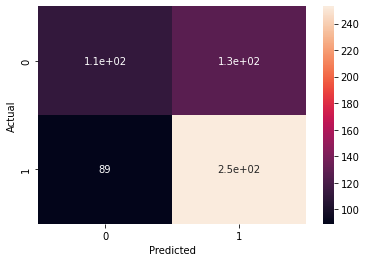

Confusion Matrix:
 [[111 127]
 [ 89 253]]
Accuracy Score: 0.6275862068965518
Precision Score: 0.6203275862068965
Recall Score: 0.6275862068965518
F1 Score: 0.6212316336424434


In [ ]:
true_values =  [1 if value not in no_values else 0 for value in data[metric]]
evaluation_rb.main(true_values, final_labels)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_values, final_labels))

              precision    recall  f1-score   support

           0       0.56      0.47      0.51       238
           1       0.67      0.74      0.70       342

    accuracy                           0.63       580
   macro avg       0.61      0.60      0.60       580
weighted avg       0.62      0.63      0.62       580



The confusion matrix indicates that the achieved results are slightly better than that of other metrics. However, it's clear from the above that the number of statements in the positive class is slightly greater than the number of statements in the negative class. Due to this, it may predict better in the case of the positive class statements. The further evaluation includes calculating different metrics like Accuracy, Precision, Recall, and F1-score to check how well the prediction task worked on the data.
 
 
The above results show that this method achieved overall 63% accuracy, 62% precision, and 63% recall. This method achieved slightly better results on the positive class than the negative one, which is probably the result of having more data available in the positive case.


In [ ]:
data[metric+' predicted'] = final_labels

In [ ]:
data.to_csv('./ownership-disclosure-predicted.csv')

# Testing with a sample.

In [ ]:
data_sample = data.sample(10).reset_index(drop=True)

In [ ]:

extractions = [get_sentences_w_keywords(doc, few_keywords_lemmas) for doc in tqdm.tqdm(nlp.pipe(data_sample['TEXT']))]
extractions = [get_unique_sentences(dictionaries_list) for dictionaries_list in extractions]
data_sample['extractions'] = extractions

10it [00:04,  2.39it/s]


In [ ]:
data_sample['extractions']

0    [{'element': 'parent company', 'sentence': 'Al...
1    [{'element': 'subsidiary', 'sentence': 'The Ba...
2                                                   []
3    [{'element': 'subsidiary', 'sentence': 'This S...
4    [{'element': 'subsidiary', 'sentence': 'This s...
5    [{'element': 'subsidiary', 'sentence': ', SORE...
6    [{'element': 'wholly own', 'sentence': 'Canacc...
7    [{'element': 'wholly own', 'sentence': 'It is ...
8                                                   []
9                                                   []
Name: extractions, dtype: object

In [ ]:
def example_generator(extracted_sentences):
    for sent in extracted_sentences:
        yield sent

pos_gen = example_generator(data_sample['extractions'])

In [ ]:
next(pos_gen)

[{'element': 'parent company',
  'sentence': 'Allstate’s Structure, Business and Supply Chains',
  'span': '552:600',
  'tense': 'future'},
 {'element': 'parent company',
  'sentence': 'The Allstate Corporation (parent company to Allstate)',
  'span': '601:653',
  'tense': 'future'}]

In [ ]:
next(pos_gen)

[{'element': 'subsidiary',
  'sentence': 'The Bank offers shoppers great deals, and rewards.',
  'span': '2513:2563',
  'tense': 'present'},
 {'element': 'subsidiary',
  'sentence': 'HRG is a subsidiary of Sainsbury’s Bank and provides store cards.',
  'span': '2564:2628',
  'tense': 'present'},
 {'element': 'wholly own',
  'sentence': 'Sainsbury’s Bank is a retail bank which is wholly owned by J Sainsbury’s plc.',
  'span': '1944:2020',
  'tense': 'present'}]

In [ ]:
next(pos_gen)

[]